# Network to Detect Melanoma

## Introduction
In this notebook I will document my attempt to build a convolutional neural network to analyse images of lesions and then diagnose them. This project will take the image data from the [2017 ISIC Challenge on Skin Lesion Analysis Towards Melanoma Detection](https://challenge.kitware.com/#challenge/583f126bcad3a51cc66c8d9a).  The result will be one of three different skin diseases: melanoma, nevus, or seborrheic keratosis.

The data was drawn from these three locations:

1. [Training](https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip)
2. [Validation](https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip)
3. [Testing](https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip)


## Plan
Sebastian Thrun and his team of students found that a pretrained network [performed better](https://classroom.udacity.com/nanodegrees/nd101/parts/b9c4c3c3-b524-427b-8832-9d0748f14a2e/modules/cb574ac4-7144-4ba5-97b9-1c1265525ff8/lessons/54e18898-2666-445d-ba5c-ecab62a61d00/concepts/3e74481c-c1f3-45c1-b0b5-e1cf479df45d) than an untrained network. I intend to use transfer learning from one of the following pre-trained networks: VGG-19, ResNet-50, Inception, or Xception.

I may explore other models if I have time.



## Load Data?
Maybe we will use this routine. The code below is using flow_from_directory, so perhaps not.

In [32]:
# import the necessary packages
from keras.applications import ResNet50
from keras.applications import InceptionV3
from keras.applications import Xception # TensorFlow ONLY
from keras.applications import VGG16
from keras.applications import VGG19
from keras.applications import imagenet_utils
from keras.applications.inception_v3 import preprocess_input
import numpy as np
import cv2
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12.0, 10.0]

from keras.preprocessing import image
from tqdm import tqdm

from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    class_files = np.array(data['filenames'])
    class_targets = np_utils.to_categorical(np.array(data['target']), 3)
    return class_files, class_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('data/train')
valid_files, valid_targets = load_dataset('data/valid')
test_files, test_targets = load_dataset('data/test')

## Experimental code

*Note: This code seems to be all over the internet, I forget which page I orignally copied it from, but you can find it [here](https://github.com/hbhasin/Image-Recognition-with-Deep-Learning/blob/master/classify_butterfly_image.py). I'm also borrowing code from this great resource on* [Transfer Learning using Keras](https://towardsdatascience.com/transfer-learning-using-keras-d804b2e04ef8).


In [33]:
args = {'model': 'vgg19'
	, 'image':'donkey.jpg'}


# define a dictionary that maps model names to their classes
# inside Keras
MODELS = {
    "vgg16": VGG16,
    "vgg19": VGG19,
    "inception": InceptionV3,
    "xception": Xception,  # TensorFlow ONLY
    "resnet": ResNet50
}
## MY CODE ##
FROZEN_LAYERS = {
    "vgg16": 22,  # Does not Leaves final Conv2D block
    "vgg19": 17,  #Leaves final Conv2D block
    "inception": 311,   #Don't understand it, so freezing whole thing. Final classification layers are not imported anyway.
    "xception": 132,  # TensorFlow ONLY, same note as for InceptionV3, don't understand it
    "resnet": 175  #ditto don't understand it
}

# esnure a valid model name was supplied via command line argument
if args["model"] not in MODELS.keys():
    raise AssertionError("The --model command line argument should "
                         "be a key in the `MODELS` dictionary")

# initialize the input image shape (224x224 pixels) along with
# the pre-processing function (this might need to be changed
# based on which model we use to classify our image)
inputShape = (224, 224)
input_shape = (224, 224, 3)
preprocess = imagenet_utils.preprocess_input

# if we are using the InceptionV3 or Xception networks, then we
# need to set the input shape to (299x299) [rather than (224x224)]
# and use a different image processing function
if args["model"] in ("inception", "xception"):
    inputShape = (299, 299)
    input_shape = (299,299,3)
    preprocess = preprocess_input

# load our the network weights from disk (NOTE: if this is the
# first time you are running this script for a given network, the
# weights will need to be downloaded first -- depending on which
# network you are using, the weights can be 90-575MB, so be
# patient; the weights will be cached and subsequent runs of this
# script will be *much* faster)
print("[INFO] loading {}...".format(args["model"]))
Network = MODELS[args["model"]]
model = Network(weights="imagenet", include_top=False, input_shape = input_shape)
inputShape
## My Code
#from keras import applications
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
#from keras import backend as k 


## FREEZE LAYERS
for layer in model.layers[:FROZEN_LAYERS[args["model"]]]:
    layer.trainable = False

## Define my classification layers
#Adding custom Layers 
x = model.output
x = Flatten()(x)
#x = Dense(1024, activation="relu")(x)
#x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(3, activation="softmax")(x)

# creating the final model 
model_final = Model(inputs = model.input, outputs = predictions)


[INFO] loading vgg19...


In [34]:
# load the input image using the Keras helper utility while ensuring
# the image is resized to `inputShape`, the required input dimensions
# for the ImageNet pre-trained network
#print("[INFO] loading and pre-processing image...")
#image = load_img(args["image"], target_size=inputShape)
#image = img_to_array(image)

# our input image is now represented as a NumPy array of shape
# (inputShape[0], inputShape[1], 3) however we need to expand the
# dimension by making the shape (1, inputShape[0], inputShape[1], 3)
# so we can pass it through thenetwork
#image = np.expand_dims(image, axis=0)

# pre-process the image using the appropriate function based on the
# model that has been loaded (i.e., mean subtraction, scaling, etc.)
#image = preprocess(image)


def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=inputShape)
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3) or (299, 299, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    img = np.expand_dims(x, axis=0)
    return preprocess(img)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

# pre-process the data for Keras
loaded = False
try:
    q = train_tensors[0]
    loaded = True
except:
    pass
if (loaded == False) | (last_inputShape != inputShape):
    train_tensors = paths_to_tensor(train_files).astype('float32')
    valid_tensors = paths_to_tensor(valid_files).astype('float32')
    test_tensors = paths_to_tensor(test_files).astype('float32')
    last_inputShape = inputShape


# classify the image
#print("[INFO] classifying image with '{}'...".format(args["model"]))
#preds = model.predict(image)
#P = imagenet_utils.decode_predictions(preds)

# loop over the predictions and display the rank-5 predictions +
# probabilities to our terminal
#for (i, (imagenetID, label, prob)) in enumerate(P[0]):
#    print("{}. {}: {:.2f}%".format(i + 1, label, prob * 100))

# load the image via OpenCV, draw the top prediction on the image,
# and display the image to our screen
#orig = cv2.imread(args["image"])
#(imagenetID, label, prob) = P[0][0]
#cv2.putText(orig, "Label: {}, {:.2f}%".format(label, prob * 100),
#	(10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
#cv2.imshow("Classification", orig)
#cv2.waitKey(0)


# convert BGR image to RGB for plotting
#cv_rgb = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
#plt.imshow(cv_rgb)
#plt.title('Classy')
#plt.show()

In [35]:
for i, layer in enumerate(model_final.layers):
    print(i, layer.name, layer.trainable)
model_final.summary()

0 input_3 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 False
15 block4_conv4 False
16 block4_pool False
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True
22 flatten_3 True
23 dense_3 True
24 dense_4 True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_____________________________

Another code snippet from the internet. Again, I've seen [this](https://towardsdatascience.com/transfer-learning-using-keras-d804b2e04ef8) is in more than one place.

## Hyper Parameters

In [41]:
train_data_dir = "data/train"
validation_data_dir = "data/valid"
batch_size = 40
epochs = 50
lr = 1e-3

zoom_range = 0.3
shift_range = 0.2
rotation_range = 30

import os
def filecount(dir_name):
# return the number of files in directory dir_name
    try:
        return len([f for f in os.listdir(dir_name) if os.path.isfile(os.path.join(dir_name, f))])
    except:
        return 0


dirs = os.listdir(train_data_dir)
nb_train_samples = 0
for dir_name in dirs:
    nb_train_samples += filecount(os.path.join(train_data_dir, dir_name))

dirs = os.listdir(validation_data_dir)
nb_validation_samples = 0
for dir_name in dirs:
    nb_validation_samples += filecount(os.path.join(validation_data_dir, dir_name))

print(nb_train_samples)
print(nb_validation_samples)

2000
150


In [42]:
print(train_tensors[1].shape)
print(train_targets[1].shape)

(224, 224, 3)
(3,)


In [43]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
# compile the model
opt = optimizers.RMSprop(lr=lr)
model_final.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=["accuracy"])


# Initiate the train and test generators with data Augumentation 
train_datagen = ImageDataGenerator(
rescale = 1./inputShape[0],
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = zoom_range,
width_shift_range  = shift_range,
height_shift_range = shift_range,
rotation_range     = rotation_range)

test_datagen = ImageDataGenerator(
rescale = 1./inputShape[0],
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = zoom_range,
width_shift_range  = shift_range,
height_shift_range = shift_range,
rotation_range     = rotation_range)

train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = inputShape,
batch_size = batch_size, 
class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
target_size = inputShape,
class_mode = "categorical")

# Save the model according to the conditions
modelCheckpointName = 'saved_models/' + args["model"] + '_1.hdf5'
checkpoint = ModelCheckpoint(modelCheckpointName, monitor='val_acc', verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')


# Train the model 
#hist = model_final.fit_generator(train_generator,
#    steps_per_epoch = nb_train_samples,     epochs = epochs,
#    validation_data = validation_generator, validation_steps = nb_validation_samples,
#    callbacks = [checkpoint, early])

hist = model_final.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpoint, early], verbose=2)

Found 2000 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Train on 2000 samples, validate on 150 samples
Epoch 1/50
Epoch 00000: val_acc improved from -inf to 0.52000, saving model to saved_models/vgg19_1.hdf5
21s - loss: 5.0611 - acc: 0.6860 - val_loss: 7.7367 - val_acc: 0.5200
Epoch 2/50
Epoch 00001: val_acc did not improve
20s - loss: 5.0611 - acc: 0.6860 - val_loss: 7.7367 - val_acc: 0.5200
Epoch 3/50
Epoch 00002: val_acc did not improve
19s - loss: 5.0611 - acc: 0.6860 - val_loss: 7.7367 - val_acc: 0.5200
Epoch 4/50
Epoch 00003: val_acc did not improve
20s - loss: 5.0611 - acc: 0.6860 - val_loss: 7.7367 - val_acc: 0.5200
Epoch 5/50
Epoch 00004: val_acc did not improve
20s - loss: 5.0611 - acc: 0.6860 - val_loss: 7.7367 - val_acc: 0.5200
Epoch 6/50
Epoch 00005: val_acc did not improve
20s - loss: 5.0611 - acc: 0.6860 - val_loss: 7.7367 - val_acc: 0.5200
Epoch 7/50
Epoch 00006: val_acc did not improve
20s - loss: 5.0611 - acc: 0.6860 - val_loss: 7.7367 - val

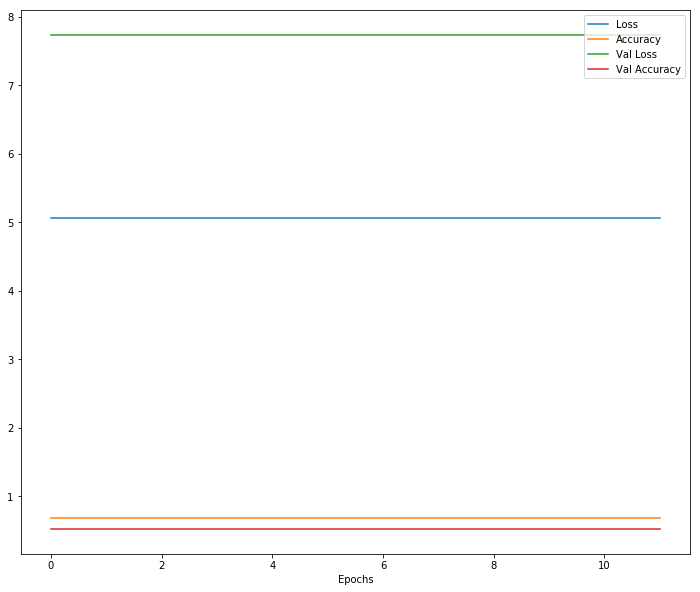

In [44]:
# ['acc', 'loss', 'val_acc', 'val_loss']
yl = hist.history['loss']
ya = hist.history['acc']
yvl = hist.history['val_loss']
yva = hist.history['val_acc']
x = np.arange(len(yl))

plt.plot(x,yl, label='Loss')
plt.plot(x,ya, label='Accuracy')
plt.plot(x,yvl, label='Val Loss')
plt.plot(x,yva, label='Val Accuracy')
plt.xlabel('Epochs')
#plt.ylabel('Loss/Accuracy')
plt.legend(loc=1)
plt.show()

In [45]:
#Load the model weights with the best validation loss.
print('Loading best weights back into model...')
model_final.load_weights(modelCheckpointName)

# Calculate classification accuracy on the test dataset.
# get index of predicted class for each image in test set
class_predictions = [np.argmax(model_final.predict(np.expand_dims(feature, axis=0)))\
                           for feature in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(class_predictions)==np.argmax(test_targets, axis=1))/len(class_predictions)
print(args["model"] + ' Test accuracy: %.4f%%' % test_accuracy)


Loading best weights back into model...
vgg19 Test accuracy: 65.5000%
